In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
%matplotlib widget
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.linalg as la
import pyvista as pv
import imageio.v3 as iio
np.set_printoptions(formatter={"float": "{:10.2f}".format})

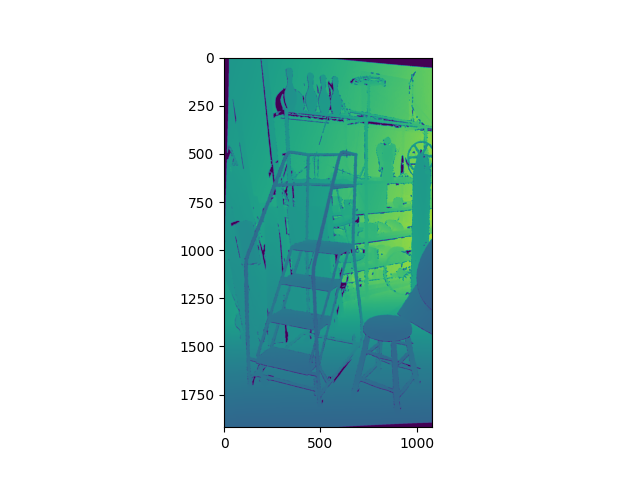

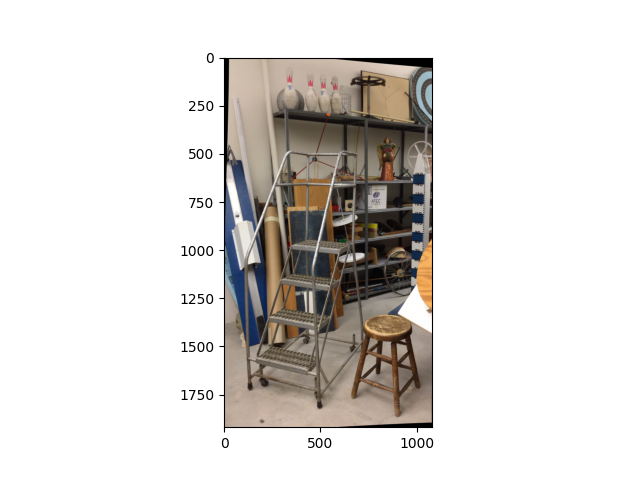

In [3]:
img_path = "c:/data/middlebury/all/data/ladder1/im0.png"
dispm_path = "c:/data/middlebury/all/data/ladder1/disp0.pfm"
f = 1733.68
cam = np.array([[f, 0, 819.72], [0, f, 957.55], [0, 0, 1]])
baseline=221.13
doffs=0

pfm = iio.imread(dispm_path,plugin="PFM-FI").astype(np.float32)


for y in range(pfm.shape[0]):
    for x in range(pfm.shape[1]):
        disp = pfm[y,x]
        if disp != 0:
            Z = baseline * f / (disp + doffs)
        else:
            Z = np.nan
        pfm[y,x] = Z

dm = np.flip(pfm,axis=0).copy()

im = iio.imread(img_path)
im = np.asarray(im)

plt.figure()
plt.imshow(dm)

plt.figure()
plt.imshow(im)


In [4]:
pts = []
invK = la.inv(cam)
for y in range(dm.shape[0]):
    for x in range(dm.shape[1]):
        dist = dm[y,x]
        pt = dist * (invK @ [x,y,1])
        pts.append(pt)

pts = np.array(pts)

In [5]:
#mesh['colors'] = my_rgb_array
#mesh.plot(scalars='colors', rgb=True, notebook=False)

mesh = pv.PolyData(pts)
mesh['colors'] = np.reshape(im,(-1,3))

#mesh.plot(scalars='colors',rgb=True, render_points_as_spheres=True,eye_dome_lighting=True,notebook=False)
mesh.plot(scalars='colors',rgb=True,notebook=False, eye_dome_lighting=True)

In [10]:
from src.dmcpworkflow.annotate_points import annotate

mpl.use("QT5Agg")
cps = annotate(im[:,:,0],dm) # exactly nonplanar 6 do seem best
%matplotlib inline
print(cps)

[[    341.27      75.14     336.06      69.92]
 [    847.27    1381.87     849.88    1397.52]
 [   1019.42     518.54    1024.63     526.37]
 [    855.10     435.08     849.88     432.47]
 [    184.78    1574.88     182.17    1577.49]
 [    915.09    1115.83     925.52    1118.44]]


In [11]:
#cps[:,2:] = cps[:,:2]

In [12]:
#cps = np.array([[ 340.53626943,  498.71808761,  340.53626943,  498.71808761],
#       [ 441.31010699,  514.22175493,  441.31010699,  514.22175493],
#       [ 689.36878407,  506.46992127,  689.36878407,  506.46992127],
#       [ 619.60228114,  496.13414306,  619.60228114,  496.13414306],
#       [ 131.23676065, 1568.47113249,  131.23676065, 1568.47113249],
#       [ 492.98899805, 1661.4931364 ,  492.98899805, 1661.4931364 ],
#       [ 418.05460602, 1436.6899603 ,  418.05460602, 1436.6899603 ],
#       [ 715.20822959, 1488.36885136,  715.20822959, 1488.36885136]])

#cps = np.array([[    702.29,    1677.00   ,  704.87  ,  1679.58],
# [    898.67  ,  1757.10   ,  898.67 ,   1754.52],
# [   1002.03,    1674.41 ,    994.27  ,  1664.08],
# [    968.43 ,   1540.05,     968.43  ,  1545.22],
# [    890.92 ,   1586.56,     885.75   , 1583.97],
# [    735.88 ,   1532.30   ,  738.46   , 1534.88],
# [    141.57 ,    863.05   ,  138.99  ,   870.81]])

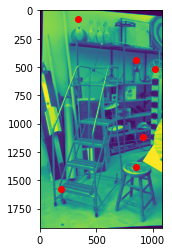

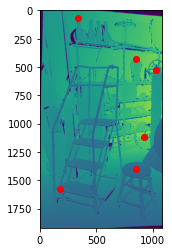

In [13]:
plt.figure()
plt.imshow(im[:,:,0])
plt.scatter(cps[:,0],cps[:,1],c="r")

plt.figure()
plt.imshow(dm,origin="upper")
plt.scatter(cps[:,2],cps[:,3],c="r")

plt.show()

In [14]:
from src.pycv.dmcp import dm_to_world
ext = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0]])
P = cam @ ext

world_pts = dm_to_world(dm, cam, P,cps[:,2:])
world_pts

array([[  -2606.93,   -4784.27,    9344.46],
       [    115.82,    1689.48,    6657.27],
       [   1175.85,   -2474.22,    9948.24],
       [    208.49,   -3629.57,   11983.92],
       [  -2519.20,    2449.63,    6850.43],
       [    787.88,    1198.11,   12910.33]], dtype=float32)

In [15]:
import pyvista as pv
cps_mesh = pv.PolyData(world_pts)
pl = pv.Plotter(off_screen=False,notebook=False)
pl.add_mesh(mesh, scalars="colors",rgb=True)
pl.add_mesh(cps_mesh, color="red", point_size=25, render_points_as_spheres=True)
pl.show()

In [16]:
from src.pycv.dmcp import dmcp
R  = np.array([ [ 0.6663311,  0.2944014,  0.6850771],
   [0.6567611,  0.2033320, -0.7261687],
  [-0.3530832,  0.9338008, -0.0578650 ]])
T = np.array([[100,100,-200]]).T
trans = np.hstack((R,T))
trans = np.vstack((trans,[0,0,0,1]))

P_im = P @ la.inv(trans)

#P_im = P

A = dmcp(cam, P_im, cps[:,:2],world_pts)
print(f"A\n{A}")

estimated pose
[[      1.00       0.00       0.01     -69.70]
 [     -0.00       1.00      -0.00      49.21]
 [     -0.01       0.00       1.00    -132.80]]
A
[[      0.67       0.65      -0.35    -272.04]
 [      0.29       0.20       0.94     187.17]
 [      0.68      -0.73      -0.05    -137.77]
 [      0.00       0.00       0.00       1.00]]


In [17]:
P_trans = P_im @ la.inv(A)

print("pose (mm)")
pos_est = la.null_space(P_trans) / la.null_space(P_trans)[-1]
pos_truth = la.null_space(P) / la.null_space(P)[-1]

pos_est = pos_est[:3].flatten()
pos_truth = pos_truth[:3].flatten()
pos_est 

pose (mm)


array([    -69.70,      49.21,    -132.80])

dmcp works with arbitrary transformation 

In [18]:
sv_est = pv.Sphere(center=pos_est,radius=500)
sv_gt = pv.Sphere(center=pos_truth,radius= 500)
pl = pv.Plotter(off_screen=False,notebook=False)
pl.add_mesh(mesh, scalars="colors",rgb=True)
pl.add_mesh(sv_gt, color="green")
pl.add_mesh(sv_est, color="blue")
pl.show()

reproject points

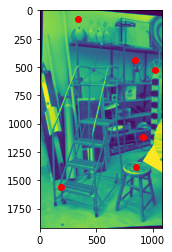

In [19]:
#P_trans @ world_pts
reprojected = P_trans @ np.hstack((world_pts,np.ones((world_pts.shape[0],1)))).T
reprojected = reprojected.T
repr0 = reprojected[:,0] / reprojected[:,-1]
repr1 = reprojected[:,1] / reprojected[:,-1]
repr = np.vstack((repr0,repr1)).T

plt.imshow(im[:,:,0])
plt.scatter(repr[:,0],repr[:,1], c="r")

#### test the same for custom depth map

In [20]:
from src.dmcpworkflow.capture_depth import generate_depth_map

tup = generate_depth_map(mesh)

[[   1196.27       0.00     512.00]
 [      0.00     897.20     384.00]
 [      0.00       0.00       1.00]]


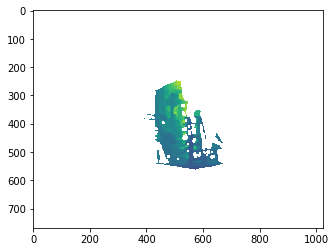

In [21]:
_dm, _dmK, _dmP = tup

print(_dmK)

plt.imshow(_dm)
plt.show()

In [24]:
from src.dmcpworkflow.annotate_points import annotate
mpl.use("QT5Agg")
_cps = annotate(im[:,:,0],_dm) # exactly nonplanar 6 do seem best
%matplotlib inline
print(_cps)

[[    742.94    1436.65     627.31     492.98]
 [    883.79    1452.30     646.09     490.89]
 [    690.78    1663.57     624.18     529.50]
 [    899.44    1739.20     652.35     528.45]
 [   1014.20     500.28     578.27     353.18]
 [   1063.76    1128.87     656.52     449.16]
 [    132.61     857.62     481.24     433.51]]


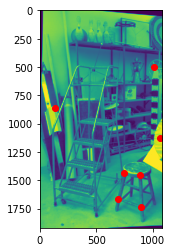

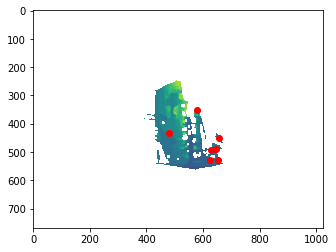

In [25]:
plt.figure()
plt.imshow(im[:,:,0])
plt.scatter(_cps[:,0],_cps[:,1],c="r")

plt.figure()
plt.imshow(_dm,origin="upper")
plt.scatter(_cps[:,2],_cps[:,3],c="r")

plt.show()

In [26]:
_world_pts = dm_to_world(_dm, _dmK, _dmP,_cps[:,2:])
_world_pts

array([[   -427.17,    2771.47,    6621.33],
       [     39.04,    2749.48,    6289.56],
       [   -579.08,    4224.01,    6851.94],
       [    147.98,    4279.39,    6402.42],
       [   1026.27,   -3312.22,    9908.01],
       [    783.10,    1132.66,    6385.81],
       [  -3860.33,     -93.76,    8914.00]], dtype=float32)

In [27]:
cps_mesh = pv.PolyData(_world_pts)
pl = pv.Plotter(off_screen=False,notebook=False)
pl.add_mesh(mesh, scalars="colors",rgb=True)
pl.add_mesh(cps_mesh, color="red", point_size=25, render_points_as_spheres=True)
pl.show()

In [28]:
_A = dmcp(_dmK, P_im, _cps[:,:2],_world_pts)
print(f"A\n{_A}")

estimated pose
[[      0.97       0.10       0.23   -3637.63]
 [     -0.04       0.98      -0.22   -2564.87]
 [     -0.24       0.20       0.95     -62.70]]
A
[[      0.85       0.44      -0.29   -2154.21]
 [      0.08       0.45       0.89    3268.03]
 [      0.52      -0.78       0.35     871.98]
 [      0.00       0.00       0.00       1.00]]


In [29]:
_P_trans = P_im @ la.inv(_A)

print("pose (mm)")
_pos_est = la.null_space(_P_trans) / la.null_space(_P_trans)[-1]
pos_truth = la.null_space(P) / la.null_space(P)[-1]

_pos_est = _pos_est[:3].flatten()
pos_truth = pos_truth[:3].flatten()
_pos_est 

pose (mm)


array([  -1966.50,    3142.51,     777.06])

In [30]:
sv_est = pv.Sphere(center=_pos_est,radius=500)
sv_gt = pv.Sphere(center=pos_truth,radius= 500)
pl = pv.Plotter(off_screen=False,notebook=False)
pl.add_mesh(mesh, scalars="colors",rgb=True)
pl.add_mesh(sv_gt, color="green")
pl.add_mesh(sv_est, color="blue")
pl.show()